<a href="https://colab.research.google.com/github/yohanes-erwin/notebook/blob/main/lstm_air_pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/Colab Notebooks

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


### Data Preprocessing

Download dataset dari internet ke google drive.

In [3]:
import requests
file_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv"
file_data = requests.get(file_url).content
with open("pollution_raw.csv", "wb") as file:
  file.write(file_data)

Menggabungkan kolom tahun, bulan, hari, dan jam menjadi satu kolom.

In [4]:
def parse(x):
 return datetime.strptime(x, '%Y %m %d %H')

In [5]:
dataset = read_csv('pollution_raw.csv', parse_dates=[['year','month','day','hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

In [6]:
dataset

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


Mengubah nama kolom.

In [7]:
dataset.columns = ['pollution','dew','temp','press','wnd_dir','wnd_spd','snow','rain']
dataset.index.name = 'date'

In [8]:
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [9]:
# Mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# Drop the first 24 hours
dataset = dataset[24:]
dataset.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


Simpan menjadi file .csv yang baru.

In [10]:
dataset.to_csv('pollution.csv')

Melakukan plot untuk visualisasi data.

In [11]:
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

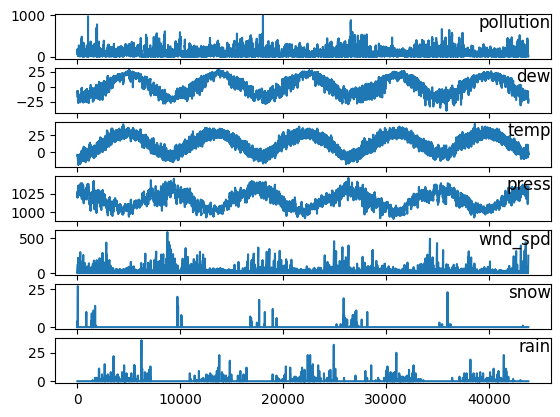

In [12]:
groups = [0,1,2,3,5,6,7]
i = 1
pyplot.figure()
for group in groups:
  pyplot.subplot(len(groups), 1, i)
  pyplot.plot(values[:,group])
  pyplot.title(dataset.columns[group], y=0.5, loc='right')
  i += 1
pyplot.show()

### Feature Scaling

Melakukan encoding untuk fitur categorical.

In [13]:
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')

In [14]:
values[0,:]

array([ 129.  ,  -16.  ,   -4.  , 1020.  ,    2.  ,    1.79,    0.  ,
          0.  ], dtype=float32)

Melakukan normalisasi feature.

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [16]:
scaled[0,:]

array([0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
       0.00229001, 0.        , 0.        ], dtype=float32)

### Data Embedding

Fungsi untuk mengubah dataset dari time serries menjadi embedding/supervised.

In [17]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # Input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # Forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # Put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # Drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [18]:
reframed = series_to_supervised(scaled, 1, 1)

In [19]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


Hapus kolom yang tidak diperlukan.

In [20]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


Membagi data menjadi train dan test.

In [21]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours,:]
test = values[n_train_hours:,:]

In [22]:
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 8) (8760,) (35039, 8) (35039,)


Mengubah input menjadi 3D (samples, timesteps, features).

In [23]:
train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


### LSTM Network

Membuat model LSTM.

In [24]:
model = Sequential()

In [25]:
model.add(LSTM(50, input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))

In [26]:
model.compile(loss='mae', optimizer='adam')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11800     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11851 (46.29 KB)
Trainable params: 11851 (46.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X,test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 5s - loss: 0.0494 - val_loss: 0.0681 - 5s/epoch - 45ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0327 - val_loss: 0.0661 - 1s/epoch - 9ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0207 - val_loss: 0.0542 - 1s/epoch - 9ms/step
Epoch 4/50
122/122 - 2s - loss: 0.0167 - val_loss: 0.0399 - 2s/epoch - 13ms/step
Epoch 5/50
122/122 - 2s - loss: 0.0153 - val_loss: 0.0248 - 2s/epoch - 13ms/step
Epoch 6/50
122/122 - 2s - loss: 0.0150 - val_loss: 0.0212 - 2s/epoch - 13ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0149 - val_loss: 0.0182 - 1s/epoch - 9ms/step
Epoch 8/50
122/122 - 2s - loss: 0.0148 - val_loss: 0.0167 - 2s/epoch - 14ms/step
Epoch 9/50
122/122 - 2s - loss: 0.0147 - val_loss: 0.0155 - 2s/epoch - 13ms/step
Epoch 10/50
122/122 - 2s - loss: 0.0146 - val_loss: 0.0147 - 2s/epoch - 14ms/step
Epoch 11/50
122/122 - 2s - loss: 0.0146 - val_loss: 0.0140 - 2s/epoch - 13ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0138 - 1s/epoch - 9ms/step
Epoch 13/50
122/122 - 2s - lo

Plot loss dari hasil training.

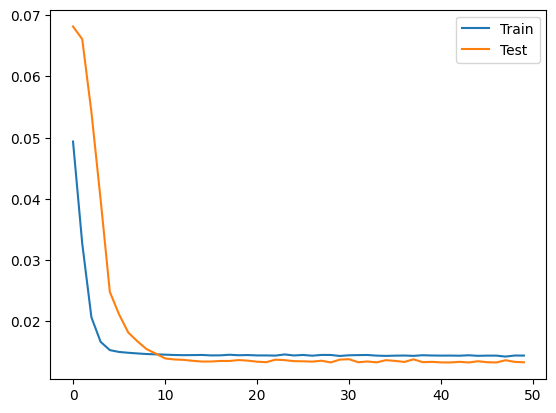

In [29]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(['Train','Test'])
pyplot.show()

### Inference

Melakukan prediksi.

In [30]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

1095/1095 [==============================] - 2s 2ms/step


Melakukan inverse normalisasi.

In [31]:
inv_yhat = concatenate((yhat,test_X[:,1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [32]:
test_y = test_y.reshape((len(test_y),1))
inv_y = concatenate((test_y,test_X[:,1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [33]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.290


Plot untuk membandingkan hasil prediksi dengan ground truth.

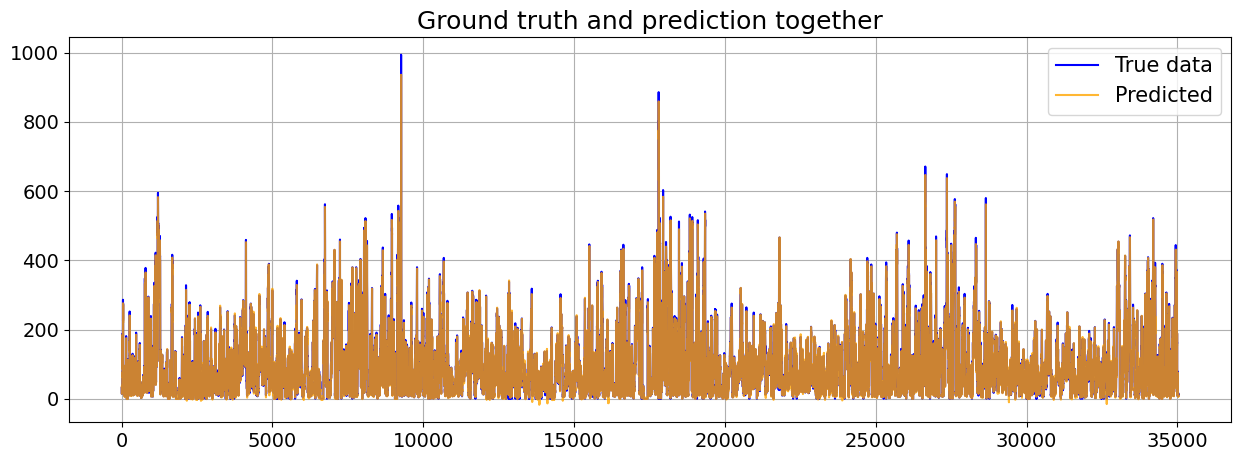

In [34]:
pyplot.figure(figsize=(15,5))
pyplot.title("Ground truth and prediction together", fontsize=18)
pyplot.plot(inv_y, c='blue')
pyplot.plot(inv_yhat, c='orange', alpha=0.8)
pyplot.legend(['True data','Predicted'], fontsize=15)
pyplot.grid(True)
pyplot.xticks(fontsize=14)
pyplot.yticks(fontsize=14)
pyplot.show()

### Improvement

Membuat model dengan multiple lag timesteps.

In [35]:
# Load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# Integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# Ensure all data is float
values = values.astype('float32')
# Normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# Specify the number of lag hours
n_hours = 3
n_features = 8
# Frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(43797, 32)


In [36]:
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.148148,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0


In [37]:
# Split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours,:]
test = values[n_train_hours:,:]
# Split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:,:n_obs], train[:,-n_features]
test_X, test_y = test[:,:n_obs], test[:,-n_features]
print(train_X.shape, len(train_X), train_y.shape)
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0],n_hours,n_features))
test_X = test_X.reshape((test_X.shape[0],n_hours,n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                11800     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11851 (46.29 KB)
Trainable params: 11851 (46.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
122/122 - 5s - loss: 0.0420 - val_loss: 0.0652 - 5s/epoch - 44ms/step
Epoch 2/50
122/122 - 2s - loss: 0.0247 - val_loss: 0.0391 - 2s/epoch - 14ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0209 - val_loss: 0.0246 - 1s/epoch - 11ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0206 - val_loss: 0.0215 - 1s/epoch - 11ms/step
Epoch 5/50
122/122 - 2s - loss: 0.0201 - val_loss: 0.0204 - 2s/epoch - 14ms/step
Epoch 6/5

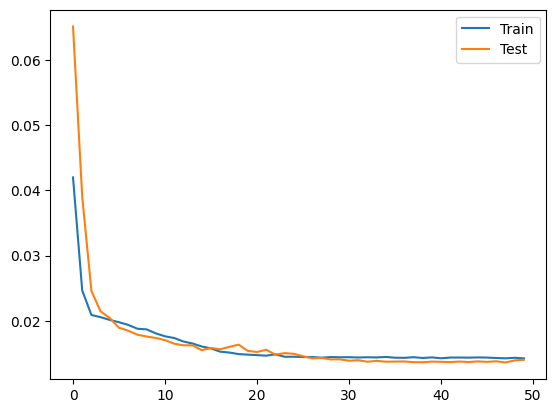

In [38]:
# Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# Fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X,test_y), verbose=2, shuffle=False)
# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(['Train','Test'])
pyplot.show()

In [39]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],n_hours*n_features))
# Invert scaling for forecast
inv_yhat = concatenate((yhat,test_X[:,-7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Invert scaling for actual
test_y = test_y.reshape((len(test_y),1))
inv_y = concatenate((test_y,test_X[:,-7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

1095/1095 [==============================] - 3s 2ms/step
Test RMSE: 26.504


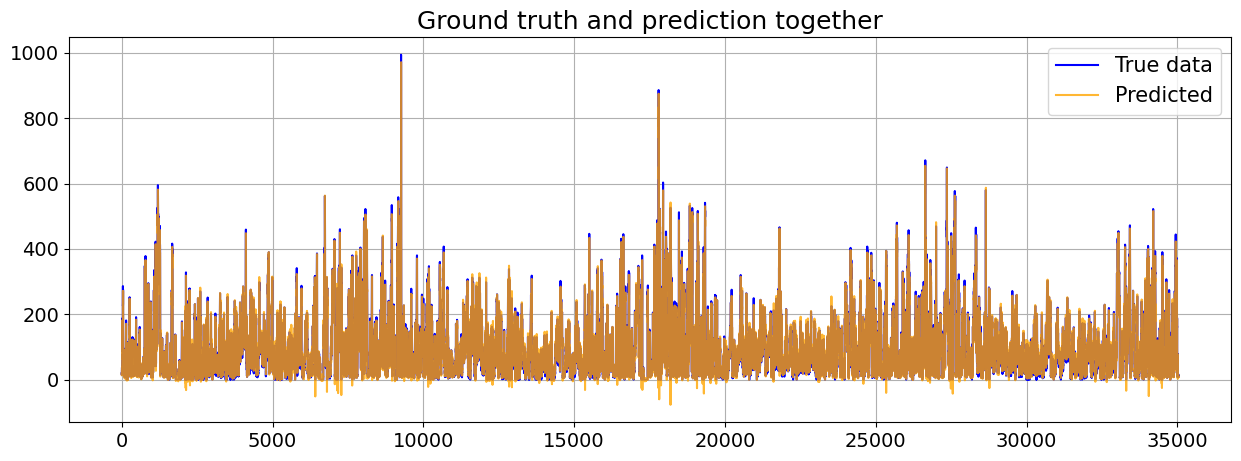

In [40]:
pyplot.figure(figsize=(15,5))
pyplot.title("Ground truth and prediction together", fontsize=18)
pyplot.plot(inv_y, c='blue')
pyplot.plot(inv_yhat, c='orange', alpha=0.8)
pyplot.legend(['True data','Predicted'], fontsize=15)
pyplot.grid(True)
pyplot.xticks(fontsize=14)
pyplot.yticks(fontsize=14)
pyplot.show()